<a href="https://colab.research.google.com/github/Tomler123/gans-generative-adversarial-networks/blob/main/Advanced_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# importing libraries

import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show(tensor, num=25, wandb=0, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)

  plt.imshow(grid.clip(0,1))
  plt.show()

### hyperparameters and general parameters
n_epochs = 10000
batch_size = 128
lr=1e-4
z_dim=200
device='cuda'
# device='cpu'

cur_step=0
crit_cycles=5
gen_lossess=[]
crit_losses=[]
show_step=35
save_step=35

In [20]:
# generator model

class Generator(nn.Module):
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim=z_dim

    self.gen = nn.Sequential(
            ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
            ## Calculating new width and height: (n-1)*stride -2*padding +ks
            ## n = width or height
            ## ks = kernel size
            ## we begin with a 1x1 image with z_dim number of channels (200)
            nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), ## 4x4 (ch: 200, 512)
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), ## 8x8 (ch: 512, 256)
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), ## 16x16 (ch: 256, 128)
            #(n-1)*stride -2*padding +ks = (8-1)*2-2*1+4=16
            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), ## 32x32 (ch: 128, 64)
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), ## 64x64 (ch: 64, 32)
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), ## 128x128 (ch: 32, 3)
            nn.Tanh() ### produce result in the range from -1 to 1
    )

  def forward(self, noise):
    x=noise.view(len(noise), self.z_dim, 1, 1) # 128 x 200 x 1 x 1
    return self.gen(x)

def gen_noise(num, z_dim, device='cuda'):
  return torch.randn(num, z_dim, device=device) # 128 x 200

In [21]:
### critic model


class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
        # nn.Conv2d: (n+2*pad-ks)//stride+1
        nn.Conv2d(3, d_dim, 4, 2, 1), # 64x64 (ch: 3, 16)
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), # 32x32 (ch: 16, 32)
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), # 16x16 (ch: 32, 64)
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), # 8x8 (ch: 64, 128)
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), # 4x4 (ch: 128, 256)
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim*16, 1, 4, 1, 0), # 1x1 (ch: 256, 1)
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2)
    )

  def forward(self, image):
    # image: 128 x 3 x 128 x 128
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred), -1) # 128 x 1

In [9]:
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip

!unzip -qq celeba_gan/data.zip -d celeba_gan

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=5a7f8636-edc6-40ca-8fe6-60ccc9af8839
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:19<00:00, 72.8MB/s]


In [10]:
# test the path
print(os.listdir('/content/celeba_gan/img_align_celeba')[0])

170787.jpg


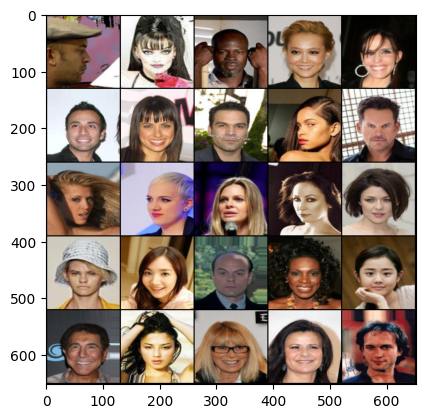

In [27]:
### Dataset, DataLoader, declare gen, crit, test dataset
path = '/content/celeba_gan/img_align_celeba'
class Dataset(Dataset):
  def __init__(self, path, size=128, lim=10000):
    self.sizes=[size, size]
    items, labels=[],[]

    for data in os.listdir(path)[:lim]:
      #path: './data/celeba/img_align_celeba'
      #data: '114568.jpg
      item = os.path.join(path,data)
      items.append(item)
      labels.append(data)
    self.items=items
    self.labels=labels


  def __len__(self):
    return len(self.items)

  def __getitem__(self,idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # (178,218)
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    data = np.transpose(data, (2,0,1)).astype(np.float32, copy=False) # 3 x 128 x 128 # from 0 to 255
    data = torch.from_numpy(data).div(255) # from 0 to 1
    return data, self.labels[idx]


# Dataset
data_path = '/content/celeba_gan/img_align_celeba'
ds = Dataset(data_path,size=128,lim=10000)

# DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

# Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))

x,y = next(iter(dataloader))
show(x)

In [28]:
# gradient penalty calculation

def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1)   # 128 x 49152
  gradient_norm = gradient.norm(2, dim=1)
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

In [29]:
## Save and load checkpoints

root_path='./content/'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  }, f"{root_path}G-{name}.pkl")

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f"{root_path}C-{name}.pkl")

  print("Saved checkpoint")

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")

In [ ]:
## Training loop

for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_bs= len(real) #128
    real=real.to(device)

    ### CRITIC
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise=gen_noise(cur_bs, z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      alpha=torch.rand(len(real),1,1,1,device=device, requires_grad=True) # 128 x 1 x 1 x 1
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss+=crit_loss.item() / crit_cycles

      crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses+=[mean_crit_loss]

    ### GENERATOR
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses+=[gen_loss.item()]

    ### Stats

    if (wandbact==1):
      wandb.log({'Epoch': epoch, 'Step': cur_step, 'Critic loss':mean_crit_loss, 'Gen loss': gen_loss})

    if cur_step % save_step == 0 and cur_step > 0:
      print("Saving checkpoint: ", cur_step, save_step)
      save_checkpoint("latest")

    if (cur_step % show_step == 0 and cur_step > 0):
      show(fake, wandbactive=1, name='fake')
      show(real, wandbactive=1, name='real')

      gen_mean=sum(gen_losses[-show_step:]) / show_step
      crit_mean = sum(crit_losses[-show_step:]) / show_step
      print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label="Generator Loss"
      )

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(crit_losses),
          label="Critic Loss"
      )

      plt.ylim(-150,150)
      plt.legend()
      plt.show()

    cur_step+=1

In [ ]:
# number of steps per epoch
# 10000 / 128 = 78.125
# 50000 / 128 = 390.625

In [ ]:
#### Generate new faces
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
plt.imshow(fake[16].detach().cpu().permute(1,2,0).squeeze().clip(0,1))

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# MORPHING, interpolation between points in latent space
gen_set=[]
z_shape=[1,200,1,1]
rows=4
steps=17

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0,1,steps):
    z=alpha*z1 + (1-alpha)*z2
    res=gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25,11))
grid=ImageGrid(fig, 111, nrows_ncols=(rows,steps), axes_pad=0.1)

for ax , img in zip (grid, gen_set):
  ax.axis('off')
  res=img.cpu().detach().permute(1,2,0)
  res=res-res.min()
  res=res/(res.max()-res.min())
  ax.imshow(res.clip(0,1.0))

plt.show()